<a href="https://colab.research.google.com/github/Mahsalo/Binary_Classification_MortalityRatePrediction/blob/main/Mortality_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the data set and importing the required libraries in each cell**

The dataset was uploaded to the Google Drive and in order to access the data we need to mount the drive and read the files.
For the purpose of pre-processing the data and data wrangling, I have used SQL using Pandas so I installed it first.

In [89]:
### Mounting the Google Drive since I have put the files on my Google Drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)


Mounted at /content/gdrive


In [90]:
 !pip install -U pandasql

Requirement already up-to-date: pandasql in /usr/local/lib/python3.7/dist-packages (0.7.3)


In [91]:
import pandas as pd
import numpy as np
import pandasql as psql

demo_train = pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Train/demographics.csv")
labs_train = pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Train/labs.csv")
vitals_train = pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Train/vitals.csv")

demo_test = pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Test/demographics.csv")
labs_test = pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Test/labs.csv")
vitals_test = pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Test/vitals.csv")

In [92]:
print('Demo. shape',demo_train.shape)
print('Vitals shape',vitals_train.shape)
print('Labs shape',labs_train.shape)

Demo. shape (64384, 29)
Vitals shape (1048575, 6)
Labs shape (759653, 6)


In [93]:
demo_train.head(10)

,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,weight,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,bodysystem_diagnosis_admit,diagnosis_admit,apache_icu_death_prob,ventilated,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,73.9,Floor,Floor,92,admit,CTICU,0.541667,0,Sepsis,502.01,0.10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,70.2,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,Respiratory,203.01,0.47,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,95.3,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,Metabolic,703.03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,61.7,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,Cardiovascular,1206.03,0.04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,NaN,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,Trauma,601.01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,74489,83,0,67.0,27.56,0,Caucasian,M,190.5,100.0,Direct Admit,Accident & Emergency,95,admit,Med-Surg ICU,0.000694,0,Neurological,403.01,0.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,49526,83,0,59.0,57.45,0,Caucasian,F,165.1,156.6,Operating Room,Accident & Emergency,95,admit,Med-Surg ICU,0.000694,0,Respiratory,203.01,0.10,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,50129,33,0,70.0,NaN,0,Caucasian,M,165.0,NaN,Emergency Department,Accident & Emergency,91,admit,Med-Surg ICU,0.002083,0,Sepsis,501.05,0.11,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,10577,118,1,45.0,NaN,0,Caucasian,M,170.2,NaN,Other,Other Hospital,114,admit,CCU-CTICU,0.009028,0,Cardiovascular,103.01,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,90749,118,0,50.0,25.71,0,NaN,M,175.3,79.0,Direct Admit,Accident & Emergency,114,admit,CCU-CTICU,0.060417,0,Cardiovascular,107.01,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Pre-processsing the data**

In order to make the data ready for the classification step we need to clean the raw data. The pre-processing of the data might contain the following operations:

- Deleting the NaN or NULL values
- replacing the missing data with mean value of each fetaure/column
- Since we have three tables (demographics, vitals, labs), we need to join these tables to add more features/columns for better classification.
- Normalization of the data using Z-score or by diving the values by the maximum absolute value (column-wise) would creat INF or -INF values so we need to check for the possible infinite or NaN values each time and remove them. 
- The dataset contains a mixture of categorical and numerical features. Some of these features were not useful (in my oppinion) so I have removed them from the dataset to better estimate the mortality rate.
- I have used only two of the categorical features "ethnicity" and "gender" for the classification and removed the rest. I have changed these categorical features into one-hot-vectors in order to turn them into numeric features.
- For the "vitals" and "labs" dataset, I have taken the average of the minimum and the maximum value of each distinct "vital" or "lab" and added them as new features to the main file. 




In [94]:
#### Removing the NaN values

demo_shape = demo_train.shape
demo_train = demo_train.dropna()
demo_test = demo_test.dropna()
vitals_train = vitals_train.dropna()
vitals_test = vitals_test.dropna()
labs_train=labs_train.dropna()
labs_test=labs_test.dropna()

**Pre-processing of Vitals file**
- I have found the average of min and max values of different distinct Vital keywords/features and added them as new features/columns to the main file.

- Some parts are commneted since they are time-consuming and I have saved their result and will read their results instead of running them again. Then I have joined the results with the previous main training dataset.

In [95]:
### Vitals Training Pre-processing
vit_sh = vitals_train.shape
newVitals= vitals_train.copy(deep=True)
vit_uni = vitals_train["Vital"].unique()
d = dict()
j=0
#for i in vit_uni:
#    newVitals[i]=0
#    d[i]=j+vit_sh[1]
#    j +=1
#for j in range(vit_sh[0]):
#        x = newVitals.iloc[j,1]
#        ind = d[x]
#        newVitals.iloc[j,ind]=(newVitals.iloc[j,2]+newVitals.iloc[j,3])/2
#        print(j)
#print(newVitals)
#newVitals.to_csv('/content/gdrive/My Drive/Amgen_DS_Challenge/Train/newVitals.csv',index=False)
#newVitalsc = newVitals.copy(deep=True)

In [96]:
newVitals=pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Train/newVitals.csv")
newVitalsc = newVitals.copy(deep=True)
q1 = "select count(*) as cnt,  * from newVitalsc group by patient_id"
newVitalsc = psql.sqldf(q1)
del newVitalsc["cnt"]
newVitalsc.head(20)

,patient_id,Vital,Min_Value,Max_Value,Unit of Measure,Time of Measure (First Day or First Hour of Stay),diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp
0,1,temp,36.3,37.1,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70
1,3,temp,37.1,37.1,Degrees Celsius,day,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.10
2,6,temp,35.5,35.5,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.50
3,8,temp,37.4,37.6,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.50
4,9,temp,36.3,36.3,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.30
5,10,temp,36.3,36.8,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.55
6,14,temp,37.8,37.8,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.80
7,15,temp,38.5,38.9,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.70
8,16,temp,36.3,37.2,Degrees Celsius,day,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.75
9,17,temp,36.4,36.4,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.40


In [97]:
newVitalsc.drop(newVitalsc.columns[[2, 3, 4,5]], axis = 1, inplace = True)
newVitalsc.head(20)

,patient_id,Vital,diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp
0,1,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70
1,3,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.10
2,6,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.50
3,8,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.50
4,9,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.30
5,10,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.55
6,14,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.80
7,15,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.70
8,16,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.75
9,17,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.40


In [98]:
q2 = "select demo.*, newVitalsc.* from demo_train demo left join newVitalsc on demo.patient_id=newVitalsc.patient_id"
newVitalsc=psql.sqldf(q2)

In [99]:
#### Changing the categorical feature gender into neumeric (0,1)
newVitalsc["gender"]=newVitalsc["gender"].replace({"M":0,"F":1})
newVitalsc.head(10)

,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,weight,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,bodysystem_diagnosis_admit,diagnosis_admit,apache_icu_death_prob,ventilated,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,patient_id,Vital,diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp
0,25312,118,0,68.0,22.730000,0,Caucasian,0,180.3,73.9,Floor,Floor,92,admit,CTICU,0.541667,0,Sepsis,502.01,0.10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25312.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.5
1,59342,81,0,77.0,27.420000,0,Caucasian,1,160.0,70.2,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,Respiratory,203.01,0.47,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,59342.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.3
2,50777,118,0,25.0,31.950000,0,Caucasian,1,172.7,95.3,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,Metabolic,703.03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50777.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.7
3,46918,118,0,81.0,22.640000,1,Caucasian,1,165.1,61.7,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,Cardiovascular,1206.03,0.04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46918.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.2
4,74489,83,0,67.0,27.560000,0,Caucasian,0,190.5,100.0,Direct Admit,Accident & Emergency,95,admit,Med-Surg ICU,0.000694,0,Neurological,403.01,0.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,74489.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.7
5,49526,83,0,59.0,57.450000,0,Caucasian,1,165.1,156.6,Operating Room,Accident & Emergency,95,admit,Med-Surg ICU,0.000694,0,Respiratory,203.01,0.10,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,49526.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.9
6,125898,77,0,72.0,28.257052,1,Hispanic,1,154.9,67.8,Operating Room,Operating Room / Recovery,113,admit,Med-Surg ICU,0.004861,0,Respiratory,1304.08,0.01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78266,83,0,80.0,27.382812,1,Caucasian,1,160.0,70.1,Operating Room,Operating Room / Recovery,95,admit,Med-Surg ICU,1.271528,0,Neurological,1505.02,0.04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,78266.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.8
8,98174,118,0,81.0,38.189067,1,Caucasian,0,172.7,113.9,Operating Room,Operating Room / Recovery,97,admit,MICU,1.376389,0,Respiratory,1304.05,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98174.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.7
9,71252,81,0,30.0,23.383178,0,Caucasian,0,193.0,87.1,Direct Admit,Accident & Emergency,90,admit,Med-Surg ICU,0.240972,0,Cardiovascular,109.14,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71252.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.5


**Pre-processing of Labs file (similar to Vitals) in the training set**
- Some parts are commneted since they are time-consuming and I have saved their result and will read their results instead of running them again. Then I have joined the results with the previous main training dataset.

In [100]:
### Do the same thing for the labs file
lab_sh = labs_train.shape
newLabs= labs_train.copy(deep=True)
lab_uni = labs_train["Lab"].unique()
d = dict()
j=0
#for i in lab_uni:
#    newLabs[i]=0
#    d[i]=j+lab_sh[1]
#    j +=1
#for j in range(lab_sh[0]):
#        x = newLabs.iloc[j,1]
#        ind = d[x]
#        newLabs.iloc[j,ind]=(newLabs.iloc[j,2]+newLabs.iloc[j,3])/2
#        print(j)
#newLabs.head(10)
#newLabs.to_csv('/content/gdrive/My Drive/Amgen_DS_Challenge/Train/newLabs.csv',index=False)

In [101]:
newLabs=pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Train/newLabs.csv")
newLabsc = newLabs.copy(deep=True)
newLabsc.drop(newLabsc.columns[[2, 3, 4,5]], axis = 1, inplace = True)


In [102]:
q3 = "select count(*) as cnt,  * from newLabsc group by patient_id"
newLabsc = psql.sqldf(q3)
del newLabsc["cnt"]
newLabsc.head(20)

,patient_id,Lab,bun,calcium,creatinine,glucose,hco3,hemaglobin,hematocrit,platelets,potassium,sodium,wbc
0,1,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.7
1,3,glucose,0.0,0.0,0.0,95.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.8
3,8,sodium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0,0.0
4,9,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.7
5,10,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7
6,14,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4
7,15,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.8
8,16,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8
9,17,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.8


In [103]:
q4 = "select newVitalsc.*, newLabsc.* from newVitalsc left join newLabsc on newVitalsc.patient_id=newLabsc.patient_id"
training_data=psql.sqldf(q4)

In [104]:
training_data.head(10)

,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,weight,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,bodysystem_diagnosis_admit,diagnosis_admit,apache_icu_death_prob,ventilated,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Vital,diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp,patient_id,Lab,bun,calcium,creatinine,glucose,hco3,hemaglobin,hematocrit,platelets,potassium,sodium,wbc
0,25312.0,118,0,68.0,22.730000,0,Caucasian,0,180.3,73.9,Floor,Floor,92,admit,CTICU,0.541667,0,Sepsis,502.01,0.10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.5,25312.0,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.1
1,59342.0,81,0,77.0,27.420000,0,Caucasian,1,160.0,70.2,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,Respiratory,203.01,0.47,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.3,59342.0,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.7
2,50777.0,118,0,25.0,31.950000,0,Caucasian,1,172.7,95.3,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,Metabolic,703.03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.7,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,46918.0,118,0,81.0,22.640000,1,Caucasian,1,165.1,61.7,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,Cardiovascular,1206.03,0.04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.2,46918.0,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.8
4,74489.0,83,0,67.0,27.560000,0,Caucasian,0,190.5,100.0,Direct Admit,Accident & Emergency,95,admit,Med-Surg ICU,0.000694,0,Neurological,403.01,0.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.7,74489.0,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.9
5,49526.0,83,0,59.0,57.450000,0,Caucasian,1,165.1,156.6,Operating Room,Accident & Emergency,95,admit,Med-Surg ICU,0.000694,0,Respiratory,203.01,0.10,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.9,49526.0,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.9
6,NaN,77,0,72.0,28.257052,1,Hispanic,1,154.9,67.8,Operating Room,Operating Room / Recovery,113,admit,Med-Surg ICU,0.004861,0,Respiratory,1304.08,0.01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78266.0,83,0,80.0,27.382812,1,Caucasian,1,160.0,70.1,Operating Room,Operating Room / Recovery,95,admit,Med-Surg ICU,1.271528,0,Neurological,1505.02,0.04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.8,78266.0,sodium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.5,0.0
8,98174.0,118,0,81.0,38.189067,1,Caucasian,0,172.7,113.9,Operating Room,Operating Room / Recovery,97,admit,MICU,1.376389,0,Respiratory,1304.05,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.7,98174.0,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.9
9,71252.0,81,0,30.0,23.383178,0,Caucasian,0,193.0,87.1,Direct Admit,Accident & Emergency,90,admit,Med-Surg ICU,0.240972,0,Cardiovascular,109.14,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.5,71252.0,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2


In [105]:
#### Deleting some categoriacal features that are not important
x=training_data.drop(['hospital_id','hospital_admit_source','hospital_admit_source','icu_id','icu_admit_source','icu_type','icu_stay_type','bodysystem_diagnosis_admit','Vital','Lab'], axis = 1, inplace =False)


In [106]:
#### changing the categorical data (ethnicity) into a one-hot vector and add them as new columns/features (example: ethnicity)
eth_uni = x['ethnicity'].unique()
eth_d = dict()
for i in range(len(x['ethnicity'].unique())):
    nm = 'ethn'+str(i)
    x[nm]=0
    eth_d[eth_uni[i]]=len(eth_uni)*[0]
    eth_d[eth_uni[i]][i]=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
x_sh= x.shape
for j in range(x_sh[0]):
  x.iloc[j,44:]=eth_d[x.iloc[j,5]]
  #print(j)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [108]:
del x['ethnicity']

In [109]:
#### Replacing the NaN values in each column with the mean of that column
xc = x.copy(deep=True)
xc.fillna(0)
mean_values = xc.mean()
for j in range(1,len(mean_values)):
  x.iloc[:,j]=x.iloc[:,j].fillna(mean_values[j])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [110]:
x=x.dropna()
x.replace([np.inf, -np.inf], np.nan, inplace=True)

**Normalization**

In [111]:
#### Normalizing column-wise since the range of each feature is different from the rest of them (z_score)
from scipy import stats
training_labels = x.iloc[:,1]
X_array = x.iloc[:,2:]
X = X_array.to_numpy()
X_sh = X.shape
#X_train = stats.zscore(X,axis =0,nan_policy='omit')
#### zscore gives nan values when std = 0 so I would normalize by dividing the values by the maximum value (taken from the absolute values)

maxx = np.amax(abs(X),axis=0) ###column-wise maximum
print(X[2,:])
for j in range(X_sh[1]):
  if maxx[j]:
    X[:,j]= X[:,j]/maxx[j]
  else:
    X[:,j]= X[:,j]/0.005

  print(maxx[j])
X_train = X  

[2.50000000e+01 3.19500000e+01 0.00000000e+00 1.00000000e+00
 1.72700000e+02 9.53000000e+01 6.94444000e-04 0.00000000e+00
 7.03030000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.67000000e+01 5.58299106e+04 0.00000000e+00 1.17073976e-03
 4.02245707e-04 4.60046235e+00 5.94451783e-04 7.15488771e-03
 1.49567371e-01 2.02121037e-01 4.35683620e-02 8.68034676e+00
 1.06200846e+01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
89.0
67.81498973
1.0
1.0
195.59
186.0
63.04444444
0.0
2201.05
0.98
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
95.5
133.5
209.0
39.4
111000.0
0.0
9.25
1.94
487.0
18.0
16.3
50.75
571.225
7.15
157.0
44.102
1.0
1.0
1.0
1.0
1.0
1.0


In [112]:
### Last check for the data
print('Shape of the training',X_train.shape)
print('Training Labels',training_labels.shape)
print(np.isnan(X_train.any()))
print(np.isfinite(X_train.any()))
X_train= X_train[~np.isnan(X_train).any(axis=1)]

Shape of the training (31651, 47)
Training Labels (31651,)
False
True


**Classification Step**

- In order to estimate the mortality ratio, we need to do a binary classification first. We have two classes using the "hospital_death" column in the Training dataset (demographics). It's binary classification since the "hspital_death" is either 1 or 0. 
- I have trained 3 different binary classifiers including Logisstic Regression, SVM, Random Forest to compare the results.
- Since the Train dataset is only labeled, I have splitted this dataset into train and test in order to evaluate my models and then in order to compute the mortality rate, I have used the unlabeled Test set.
- I have used k-fold cross validation (k=5 by default) to find the best model and the results show that random forest is better than the other two classifiers. Logistic regression is the worst. 
- So I just consider the random forest classifier as my final classifier and estimate the mortality rate (number of ones in the labels/total number of labels) for the unlabeld test set.



In [113]:
#### Data splitting for computing the train/test accuracy, allocate a part of the training to the test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, training_labels, test_size = 0.3)

In [114]:
##### Binary classification using Logistic Regression 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)
lr.score(x_test,y_test)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9219671440606572

In [115]:
##### Binary classification using SVM
from sklearn.svm import SVC
svm = SVC()
clf = svm.fit(x_train, y_train)
clf.score(x_test,y_test)

0.9214406065711879

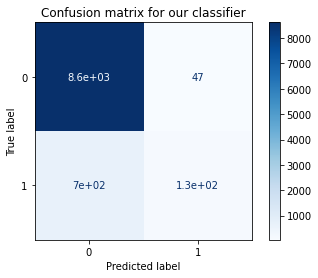

In [116]:
#### Confusion matrix for svm classifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues)
                                 
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

In [117]:
#### Binary classification using Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=40)
rf.fit(x_train,y_train)
rf.score(x_test,y_test)


0.923441449031171

In [118]:
#### K-fold cross validation
from sklearn.model_selection import cross_val_score
cv1=cross_val_score(LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000),X_train,training_labels)
print('Logistic regression CV',cv1)


Logistic regression CV [0.86258095 0.82322275 0.80078989 0.80110585 0.83949447]


In [119]:
cv2 = cross_val_score(SVC(),X_train,training_labels)
print('SVM CV',cv2)


SVM CV [0.92481441 0.92812006 0.92338073 0.92338073 0.92322275]


In [120]:
cv3 = cross_val_score(RandomForestClassifier(n_estimators=40),X_train,training_labels)
print('Random Forest CV',cv3)
cv3.mean

Random Forest CV [0.92749961 0.93033175 0.9221169  0.92527646 0.92417062]


<function ndarray.mean>

**Comparison of the models**


- The mean of the accuracies shows that Random Forest is slightly better than SVM and the Logistic Regression method has the poorest performance among all.

In [121]:
print('Mean Logistic regression CV',cv1.mean())
print('Mean SVM CV',cv2.mean())
print('Mean Random Forest CV',cv3.mean())

Mean Logistic regression CV 0.8254387810126106
Mean SVM CV 0.9245837341420124
Mean Random Forest CV 0.9258790679429663


**Pre-processing of the test set (similar operations as before)**
- If I had more time I would write a pre-processing function which would do the the same operations for each training and test set and thus there would be no need to repeat the operations each time.  

- I have provided the newVitals, newLabs, newVitals_ts and newLabs_ts CSV files in the my submission but if you would like to get these files directly, you can uncomment the commented parts and get the results.

In [122]:
### Vitals Testing Pre-processing
vit_sh_ts = vitals_test.shape
newVitals_ts= vitals_test.copy(deep=True)
vit_uni_ts = vitals_test["Vital"].unique()
d = dict()
j=0

#for i in vit_uni_ts:
#    newVitals_ts[i]=0
#    d[i]=j+vit_sh_ts[1]
#    j +=1
#for j in range(vit_sh_ts[0]):
#        x = newVitals_ts.iloc[j,1]
#        ind = d[x]
#        newVitals_ts.iloc[j,ind]=(newVitals_ts.iloc[j,2]+newVitals_ts.iloc[j,3])/2
#        print(j)
#print(newVitals_ts)
#newVitals_ts.to_csv('/content/gdrive/My Drive/Amgen_DS_Challenge/Test/newVitals_ts.csv',index=False)

In [123]:
newVitals_ts=pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Test/newVitals_ts.csv")
newVitalsc_ts = newVitals_ts.copy(deep=True)
q1 = "select count(*) as cnt,  * from newVitalsc_ts group by patient_id"
newVitalsc_ts = psql.sqldf(q1)
del newVitalsc_ts["cnt"]
newVitalsc_ts.head(20)

,patient_id,Vital,Min Value,Max Value,Unit of Measure,Time of Measure (First Day or First Hour of Stay),diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp
0,2,temp,35.1,36.8,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.95
1,4,temp,36.3,38.6,Degrees Celsius,day,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.45
2,5,temp,36.7,36.7,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70
3,7,temp,35.5,35.5,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.50
4,12,temp,36.7,36.7,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70
5,20,temp,35.4,36.4,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.90
6,25,sysbp_noninvasive,121.0,136.0,Millimetres of mercury,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.5,0.00
7,29,temp,36.8,36.8,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80
8,31,temp,36.6,37.3,Degrees Celsius,day,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.95
9,33,temp,36.3,36.3,Degrees Celsius,hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.30


In [124]:
newVitalsc_ts.drop(newVitalsc_ts.columns[[2, 3, 4,5]], axis = 1, inplace = True)
newVitalsc_ts.head(20)

,patient_id,Vital,diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp
0,2,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.95
1,4,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.45
2,5,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70
3,7,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.50
4,12,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70
5,20,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.90
6,25,sysbp_noninvasive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.5,0.00
7,29,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80
8,31,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.95
9,33,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.30


In [125]:
q2 = "select demo.*, newVitalsc_ts.* from demo_test demo left join newVitalsc_ts on demo.patient_id=newVitalsc_ts.patient_id"
newVitalsc_ts=psql.sqldf(q2)

In [126]:
#### Changing the categorical feature gender into neumeric (0,1)
newVitalsc_ts["gender"]=newVitalsc_ts["gender"].replace({"M":0,"F":1})
newVitalsc_ts.head(10)

,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,weight,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,bodysystem_diagnosis_admit,diagnosis_admit,apache_icu_death_prob,ventilated,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,patient_id,Vital,diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp
0,127144,89,75.0,26.891178,0,Other/Unknown,1,165.10,73.30,Direct Admit,Accident & Emergency,133,admit,Med-Surg ICU,0.000000,0,Sepsis,501.06,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127144.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.94740
1,39394,89,61.0,20.318327,0,Caucasian,0,172.70,60.60,Direct Admit,Accident & Emergency,133,admit,Med-Surg ICU,0.000000,0,Sepsis,501.04,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39394.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.10000
2,109113,89,69.0,34.376905,0,Caucasian,1,167.64,96.61,Emergency Department,Accident & Emergency,133,admit,Med-Surg ICU,0.000000,0,Cardiovascular,107.01,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109113.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.30000
3,31062,89,89.0,38.344957,0,Caucasian,1,175.20,117.70,Direct Admit,Accident & Emergency,133,admit,Med-Surg ICU,0.000000,0,Gastrointestinal,306.01,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31062.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80000
4,123682,89,71.0,53.971804,0,Caucasian,1,154.90,129.50,Direct Admit,Accident & Emergency,133,admit,Med-Surg ICU,0.000000,0,Sepsis,501.05,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123682.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.20000
5,53443,89,49.0,27.385356,0,Native American,0,193.04,102.05,Floor,Floor,133,admit,Med-Surg ICU,3.277083,0,Trauma,601.03,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53443.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.61404
6,3313,89,84.0,30.075826,0,Caucasian,0,188.00,106.30,Direct Admit,Accident & Emergency,133,admit,Med-Surg ICU,0.000000,0,Neurological,401.01,0.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3313.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.89184
7,34533,140,70.0,18.390675,0,Caucasian,0,188.00,65.00,Emergency Department,Accident & Emergency,126,admit,Med-Surg ICU,0.025694,0,Sepsis,501.06,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34533.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70000
8,101199,140,85.0,27.709478,0,Caucasian,1,149.86,62.23,Emergency Department,Accident & Emergency,126,admit,Med-Surg ICU,0.007639,0,Metabolic,703.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101199.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80000
9,116995,140,49.0,36.947432,0,Caucasian,0,185.40,127.00,Emergency Department,Accident & Emergency,126,admit,Med-Surg ICU,0.000000,0,Respiratory,207.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116995.0,temp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.40000


In [127]:
### Labs Testing Pre-processing
lab_sh_ts = labs_test.shape
newLabs_ts= labs_test.copy(deep=True)
lab_uni_ts = labs_test["Lab"].unique()
d = dict()
j=0

#for i in lab_uni_ts:
#    newLabs_ts[i]=0
#    d[i]=j+lab_sh_ts[1]
#    j +=1
#for j in range(lab_sh_ts[0]):
#        x = newLabs_ts.iloc[j,1]
#        ind = d[x]
#        newLabs_ts.iloc[j,ind]=(newLabs_ts.iloc[j,2]+newLabs_ts.iloc[j,3])/2
#        print(j)
#newLabs_ts.head(10)
#newLabs_ts.to_csv('/content/gdrive/My Drive/Amgen_DS_Challenge/Test/newLabs_ts.csv',index=False)

In [128]:
newLabs_ts=pd.read_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Test/newLabs_ts.csv")
newLabsc_ts = newLabs_ts.copy(deep=True)
newLabsc_ts.drop(newLabsc_ts.columns[[2, 3, 4,5]], axis = 1, inplace = True)

In [129]:
q3 = "select count(*) as cnt,  * from newLabsc_ts group by patient_id"
newLabsc_ts = psql.sqldf(q3)
del newLabsc_ts["cnt"]
newLabsc_ts.head(20)


,patient_id,Lab,bun,calcium,creatinine,glucose,hco3,hemaglobin,hematocrit,platelets,potassium,sodium,wbc
0,2,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.11
1,4,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.70
2,5,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.20
3,7,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.50
4,12,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.60
5,20,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.80
6,25,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.78
7,29,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.75
8,31,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.50
9,33,wbc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.27


In [130]:
q4 = "select newVitalsc_ts.*, newLabsc_ts.* from newVitalsc_ts left join newLabsc_ts on newVitalsc_ts.patient_id=newLabsc_ts.patient_id"
test_data=psql.sqldf(q4)

In [131]:
#### Deleting some categoriacal features that are not important
x=test_data.drop(['hospital_id','hospital_admit_source','hospital_admit_source','icu_id','icu_admit_source','icu_type','icu_stay_type','bodysystem_diagnosis_admit','Vital','Lab'], axis = 1, inplace =False)
x.head(10)

,patient_id,age,bmi,elective_surgery,ethnicity,gender,height,weight,pre_icu_los_days,readmission_status,diagnosis_admit,apache_icu_death_prob,ventilated,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp,patient_id,bun,calcium,creatinine,glucose,hco3,hemaglobin,hematocrit,platelets,potassium,sodium,wbc
0,127144.0,75.0,26.891178,0,Other/Unknown,1,165.10,73.30,0.000000,0,501.06,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.94740,127144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.35
1,39394.0,61.0,20.318327,0,Caucasian,0,172.70,60.60,0.000000,0,501.04,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.10000,39394.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.90
2,109113.0,69.0,34.376905,0,Caucasian,1,167.64,96.61,0.000000,0,107.01,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.30000,109113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.50
3,31062.0,89.0,38.344957,0,Caucasian,1,175.20,117.70,0.000000,0,306.01,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80000,31062.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.40
4,123682.0,71.0,53.971804,0,Caucasian,1,154.90,129.50,0.000000,0,501.05,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.20000,123682.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.90
5,53443.0,49.0,27.385356,0,Native American,0,193.04,102.05,3.277083,0,601.03,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.61404,53443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.80
6,3313.0,84.0,30.075826,0,Caucasian,0,188.00,106.30,0.000000,0,401.01,0.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.89184,3313.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.80
7,34533.0,70.0,18.390675,0,Caucasian,0,188.00,65.00,0.025694,0,501.06,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70000,34533.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.60
8,101199.0,85.0,27.709478,0,Caucasian,1,149.86,62.23,0.007639,0,703.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80000,101199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.70
9,116995.0,49.0,36.947432,0,Caucasian,0,185.40,127.00,0.000000,0,207.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.40000,116995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00


In [132]:
#### changing the categorical data (ethnicity) into a one-hot vector and add them as new columns/features (example: ethnicity)
eth_uni = x['ethnicity'].unique()
eth_d = dict()
for i in range(len(x['ethnicity'].unique())):
    nm = 'ethn'+str(i)
    x[nm]=0
    eth_d[eth_uni[i]]=len(eth_uni)*[0]
    eth_d[eth_uni[i]][i]=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [133]:
x.head(10)


,patient_id,age,bmi,elective_surgery,ethnicity,gender,height,weight,pre_icu_los_days,readmission_status,diagnosis_admit,apache_icu_death_prob,ventilated,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diasbp,diasbp_noninvasive,heartrate,mbp,mbp_noninvasive,resprate,spo2,sysbp,sysbp_noninvasive,temp,patient_id,bun,calcium,creatinine,glucose,hco3,hemaglobin,hematocrit,platelets,potassium,sodium,wbc,ethn0,ethn1,ethn2,ethn3,ethn4,ethn5
0,127144.0,75.0,26.891178,0,Other/Unknown,1,165.10,73.30,0.000000,0,501.06,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.94740,127144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.35,0,0,0,0,0,0
1,39394.0,61.0,20.318327,0,Caucasian,0,172.70,60.60,0.000000,0,501.04,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.10000,39394.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.90,0,0,0,0,0,0
2,109113.0,69.0,34.376905,0,Caucasian,1,167.64,96.61,0.000000,0,107.01,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.30000,109113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.50,0,0,0,0,0,0
3,31062.0,89.0,38.344957,0,Caucasian,1,175.20,117.70,0.000000,0,306.01,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80000,31062.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.40,0,0,0,0,0,0
4,123682.0,71.0,53.971804,0,Caucasian,1,154.90,129.50,0.000000,0,501.05,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.20000,123682.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.90,0,0,0,0,0,0
5,53443.0,49.0,27.385356,0,Native American,0,193.04,102.05,3.277083,0,601.03,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.61404,53443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.80,0,0,0,0,0,0
6,3313.0,84.0,30.075826,0,Caucasian,0,188.00,106.30,0.000000,0,401.01,0.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.89184,3313.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.80,0,0,0,0,0,0
7,34533.0,70.0,18.390675,0,Caucasian,0,188.00,65.00,0.025694,0,501.06,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.70000,34533.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.60,0,0,0,0,0,0
8,101199.0,85.0,27.709478,0,Caucasian,1,149.86,62.23,0.007639,0,703.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.80000,101199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.70,0,0,0,0,0,0
9,116995.0,49.0,36.947432,0,Caucasian,0,185.40,127.00,0.000000,0,207.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.40000,116995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,0,0,0,0,0


In [134]:
x_sh= x.shape
for j in range(x_sh[0]):
    
    x.iloc[j,43:]=eth_d[x.iloc[j,4]]
    #print(j)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [135]:
del x['ethnicity']

In [136]:
#### Replacing the NaN values in each column with the mean of that column
xc = x.copy(deep=True)
xc.fillna(0)
mean_values = xc.mean()
for j in range(1,len(mean_values)):
   x.iloc[:,j]=x.iloc[:,j].fillna(mean_values[j])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [137]:
x=x.dropna()
x.replace([np.inf, -np.inf], np.nan, inplace=True)

In [138]:
#### Normalizing column-wise since the range of each feature is different from the rest of them 
#### I have used the same maximum values that I found for the training set and used it for the test set as well.

training_labels = x.iloc[:,1]
X_array_ts = x.iloc[:,1:]
X = X_array_ts.to_numpy()
X_sh = X.shape

#maxx = np.amax(abs(X),axis=0) ###column-wise maximum
for j in range(X_sh[1]):
  if maxx[j]:
    X[:,j]= X[:,j]/maxx[j]
  else:
    X[:,j]= X[:,j]/0.005

  #print(maxx[j])
X_test = X  

**Prediction Using Random Forest Classifier**

- Since the test set is not labeled, I have considered a threshold myself for computing the mortality rate. If the output of the classifier is less than the threshold, it's 0 otherwise, it's 1. 

- The mortality rate is (# of predicted ones)/(Total # of test samples)


In [139]:
##### Finding the mortality rate
y_pred = rf.predict_proba(X_test)
pred_sh = y_pred.shape
s = 0
threshold = 0.5
for j in range(pred_sh[0]):
    if y_pred[j,1]>=threshold:
      s +=1

mortality_rate = s/pred_sh[0]   
print("The mortality rate of the test set is equal to {x} percent".format(x=np.round(mortality_rate*100)))    

The mortality rate of the test set is equal to 3.0 percent


In [140]:
#### Saving the prediction probabilities
y_pred_df = pd.DataFrame(y_pred)
output_file = pd.DataFrame({'patient_id':[]})
output_file['patient_id'] = x.iloc[:,0]
output_file["Survival prob."] = y_pred_df.iloc[:,0]
output_file["Death prob."] = y_pred_df.iloc[:,1]

output_file.to_csv("/content/gdrive/My Drive/Amgen_DS_Challenge/Test/output_file.csv",index=False)

In [141]:
output_file.head(10)

,patient_id,Survival prob.,Death prob.
0,127144.0,0.850,0.150
1,39394.0,0.775,0.225
2,109113.0,1.000,0.000
3,31062.0,0.725,0.275
4,123682.0,0.825,0.175
5,53443.0,0.925,0.075
6,3313.0,0.900,0.100
7,34533.0,1.000,0.000
8,101199.0,1.000,0.000
9,116995.0,1.000,0.000
